第1步：能量 = -0.76719909 Ha | β_0 = +0.000000
第10步：能量 = -0.81870477 Ha | β_9 = +0.343642
第20步：能量 = -0.98247321 Ha | β_19 = +0.390729
第30步：能量 = -1.08685996 Ha | β_29 = +0.265385
第40步：能量 = -1.12754251 Ha | β_39 = +0.164213
 Converged at step 40!
 Energy change ΔE = 2.16e-03 Ha < 1e-6
 different from E_set = 9.74e-03 Ha < 1e-3
rz: 2203
sx: 2027
cz: 1674
rx: 640
rzz: 240
Gate median errors (percentage):
id: 0.0002738%
rx: 0.0002738%
rz: 0.0%
sx: 0.0002738%
x: 0.0002738%
cz: 0.001947%
rzz: 0.00249%
Gate: id, Count: 0, Error: 0.0002738, Contribution: 1.000000
Gate: rx, Count: 640, Error: 0.0002738, Contribution: 0.839242
Gate: rz, Count: 2203, Error: 0.0, Contribution: 1.000000
Gate: sx, Count: 2027, Error: 0.0002738, Contribution: 0.574033
Gate: x, Count: 0, Error: 0.0002738, Contribution: 1.000000
Gate: cz, Count: 1674, Error: 0.001947, Contribution: 0.038294
Gate: rzz, Count: 240, Error: 0.00249, Contribution: 0.549721

Final expected fidelity ≈ 0.010141444179367014


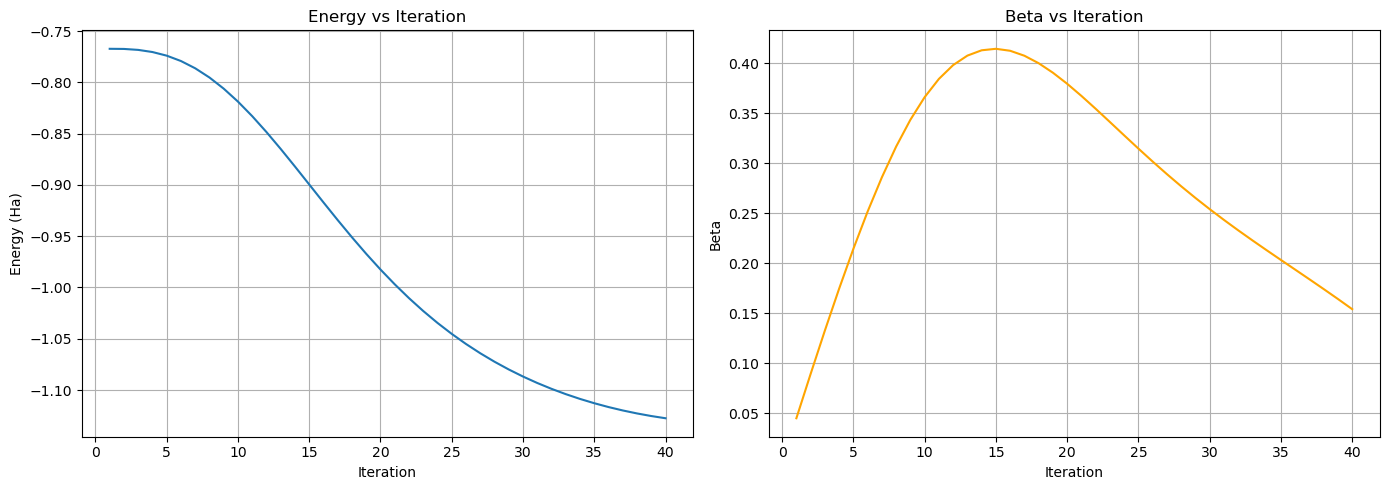

In [26]:
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler import CouplingMap

n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])


def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h=build_commutator(driver_h, cost_h)

def falqon_layer(qc,cost_h,driver_h,beta_k,delta_t):
    #synth = SuzukiTrotter(reps=1)   ,synthesis=synth
    U_c= PauliEvolutionGate(cost_h,delta_t)
    U_d= PauliEvolutionGate(beta_k*driver_h,delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set =-1.13728383

def main_loop(qc,cost_h,driver_h,comm_h,delta_t,beta_0,n_steps):
    beta =[beta_0]
    energies=[]
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer,cost_h,driver_h,beta[i],delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta =-1*state.expectation_value(comm_h).real
        beta.append(next_beta)
        if (i + 1) % 10 == 0 or i == 0:
            print(f"第{i + 1}步：能量 = {energy:.8f} Ha | β_{i} = {beta[i]:+.6f}")

        if i >= 1:
            energy_diff = abs(energies[-1] - energies[-2])
            diff_to_target = abs(energies[-1] - E_set)
            if  diff_to_target < 1e-2:
                print(f" Converged at step {i + 1}!")
                print(f" Energy change ΔE = {energy_diff:.2e} Ha < 1e-6")
                print(f" different from E_set = {diff_to_target:.2e} Ha < 1e-3")
                break
        
        
    return beta, energies, qc


def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))  # 对所有 qubit 施加 H 门
    return qc

qc_initial= uniform_superposition_circuit()

n_steps = 1000
beta_0 = 0.0
delta_t = 0.1
s_beta, s_energies, final_circuit = main_loop(
    qc=qc_initial,
    cost_h=cost_h,
    driver_h=driver_h,
    comm_h=comm_h,
    delta_t=delta_t,
    beta_0=beta_0,
    n_steps=n_steps
)

basis_gates = ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']


coupling_map = CouplingMap.from_full(4)


# 定义线性拓扑：0–1–2–3
linear_coupling = CouplingMap(couplinglist=[(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)])
transpiled_circuit= transpile(
    final_circuit,
    basis_gates=basis_gates,  # 典型 IBM 超导平台的基础门集合
    coupling_map=linear_coupling,  # 线性拓扑
    optimization_level=1
)

for gate, count in transpiled_circuit.count_ops().items():
    print(f"{gate}: {count}")

# Combined gate errors (median values, in percentage)
gate_error = {
    "id": 2.738e-4,      # 1-qubit
    "rx": 2.738e-4,      # 1-qubit
    "rz": 0.0,           # 1-qubit
    "sx": 2.738e-4,      # 1-qubit
    "x": 2.738e-4,       # 1-qubit
    "cz": 1.947e-3,      # 2-qubit
    "rzz": 2.490e-3      # 2-qubit
}

# Print out for checking
print("Gate median errors (percentage):")
for gate, error in gate_error.items():
    print(f"{gate}: {error}%")

def calculate_expected_fidelity(gate_error, count_ops, readout_fidelity=1.0):
    fidelity = 1.0
    for gate, error_rate in gate_error.items():
        count = count_ops.get(gate, 0)  # 如果电路里没有这个门，默认 count=0
        fidelity *= (1 - error_rate) ** count
        print(f"Gate: {gate}, Count: {count}, Error: {error_rate}, Contribution: {(1 - error_rate) ** count:.6f}")
    fidelity *= readout_fidelity
    return fidelity

# Get gate counts from transpiled circuit
gate_counts = transpiled_circuit.count_ops()

# Calculate expected fidelity (looping through all gates in gate_error)
expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)

print(f"\nFinal expected fidelity ≈ {expected_fidelity}")

import matplotlib.pyplot as plt

# 假设 s_energies 和 s_beta 已经从主循环中返回
# 由于 s_beta 比 s_energies 多一个初始项（beta_0），绘图时要截取对应范围

# 生成迭代步列表
iterations = list(range(1, len(s_energies) + 1))

# 创建两个子图
plt.figure(figsize=(14, 5))

# 第一个子图：Energy vs Iteration
plt.subplot(1, 2, 1)
plt.plot(iterations, s_energies)
plt.title('Energy vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Energy (Ha)')
plt.grid(True)

# 第二个子图：Beta vs Iteration
plt.subplot(1, 2, 2)
plt.plot(iterations, s_beta[1:], color='orange')
plt.title('Beta vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Beta')
plt.grid(True)

plt.tight_layout()
plt.show()


Gate: id, Count: 0, Error: 0.0002738, Contribution: 1.000000
Gate: rx, Count: 288, Error: 0.0002738, Contribution: 0.924164
Gate: rz, Count: 993, Error: 0.0, Contribution: 1.000000
Gate: sx, Count: 905, Error: 0.0002738, Contribution: 0.780498
Gate: x, Count: 0, Error: 0.0002738, Contribution: 1.000000
Gate: cz, Count: 750, Error: 0.001947, Contribution: 0.231848
Gate: rzz, Count: 108, Error: 0.00249, Contribution: 0.763948
Threshold: 0.200000, Expected Fidelity: 0.127758
Gate: id, Count: 0, Error: 0.0002738, Contribution: 1.000000
Gate: rx, Count: 320, Error: 0.0002738, Contribution: 0.916102
Gate: rz, Count: 1103, Error: 0.0, Contribution: 1.000000
Gate: sx, Count: 1007, Error: 0.0002738, Contribution: 0.758999
Gate: x, Count: 0, Error: 0.0002738, Contribution: 1.000000
Gate: cz, Count: 834, Error: 0.001947, Contribution: 0.196837
Gate: rzz, Count: 120, Error: 0.00249, Contribution: 0.741431
Threshold: 0.164584, Expected Fidelity: 0.101476
Gate: id, Count: 0, Error: 0.0002738, Contri

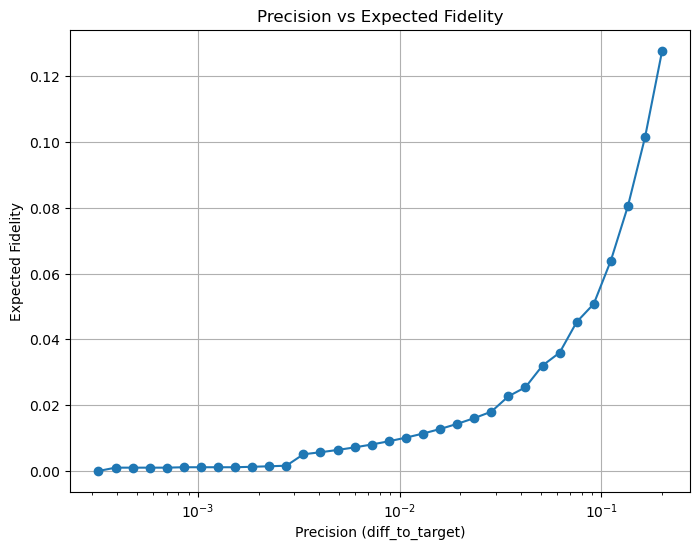

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# 修改 main_loop 增加 diff_threshold 参数
def main_loop_2(qc, cost_h, driver_h, comm_h, delta_t, beta_0, n_steps, diff_threshold):
    beta = [beta_0]
    energies = []
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer, cost_h, driver_h, beta[i], delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta = -1 * state.expectation_value(comm_h).real
        beta.append(next_beta)

        if i >= 1:
            diff_to_target = abs(energies[-1] - E_set)
            if diff_to_target < diff_threshold:
                break

    return beta, energies, qc

# 生成 diff_to_target 阈值数组
precision_list = np.logspace(np.log10(0.2), np.log10(0.0001), 40)
fidelity_list = []

for threshold in precision_list:
    # 初始化电路
    qc_initial = uniform_superposition_circuit()
    
    # 运行 main_loop
    s_beta, s_energies, final_circuit = main_loop_2(
        qc=qc_initial,
        cost_h=cost_h,
        driver_h=driver_h,
        comm_h=comm_h,
        delta_t=delta_t,
        beta_0=beta_0,
        n_steps=n_steps,
        diff_threshold=threshold
    )

    # Transpile 电路
    transpiled_circuit = transpile(
        final_circuit,
        basis_gates=basis_gates,
        coupling_map=linear_coupling,
        optimization_level=1
    )

    # 统计 gate count
    gate_counts = transpiled_circuit.count_ops()

    # 计算 expected fidelity
    expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)
    fidelity_list.append(expected_fidelity)
    print(f"Threshold: {threshold:.6f}, Expected Fidelity: {expected_fidelity:.6f}")
    if fidelity_list[-1] < 0.0001:
        print("Expected fidelity reached zero, exiting loop early.")
        break

# 绘图
# 绘图
plt.figure(figsize=(8, 6))
plt.plot(precision_list[:len(fidelity_list)], fidelity_list, marker='o')
plt.xscale('log')
plt.xlabel('Precision (diff_to_target)')
plt.ylabel('Expected Fidelity')
plt.title('Precision vs Expected Fidelity')
plt.grid(True)
plt.show()




Gate: id, Count: 0, Error: 0.0002738, Contribution: 1.000000
Gate: rx, Count: 288, Error: 0.0002738, Contribution: 0.924164
Gate: rz, Count: 993, Error: 0.0, Contribution: 1.000000
Gate: sx, Count: 905, Error: 0.0002738, Contribution: 0.780498
Gate: x, Count: 0, Error: 0.0002738, Contribution: 1.000000
Gate: cz, Count: 750, Error: 0.001947, Contribution: 0.231848
Gate: rzz, Count: 108, Error: 0.00249, Contribution: 0.763948
Threshold: 0.200000, Expected Fidelity: 0.127758, Total Gates: 3044
Gate: id, Count: 0, Error: 0.0002738, Contribution: 1.000000
Gate: rx, Count: 320, Error: 0.0002738, Contribution: 0.916102
Gate: rz, Count: 1103, Error: 0.0, Contribution: 1.000000
Gate: sx, Count: 1007, Error: 0.0002738, Contribution: 0.758999
Gate: x, Count: 0, Error: 0.0002738, Contribution: 1.000000
Gate: cz, Count: 834, Error: 0.001947, Contribution: 0.196837
Gate: rzz, Count: 120, Error: 0.00249, Contribution: 0.741431
Threshold: 0.164584, Expected Fidelity: 0.101476, Total Gates: 3384
Gate: 

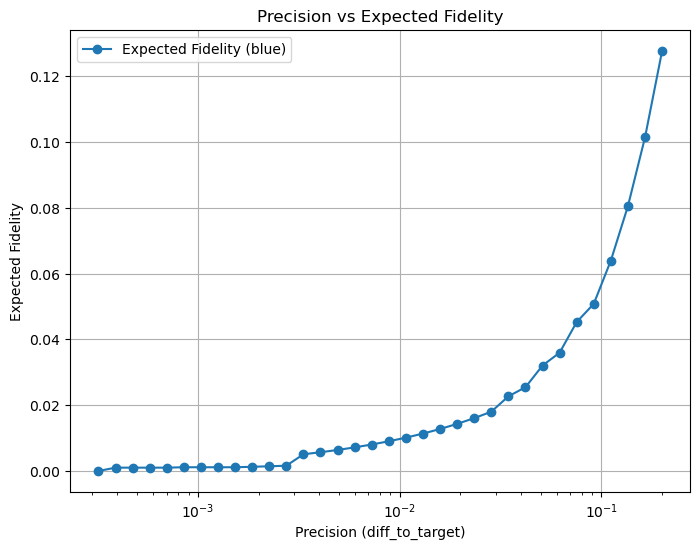

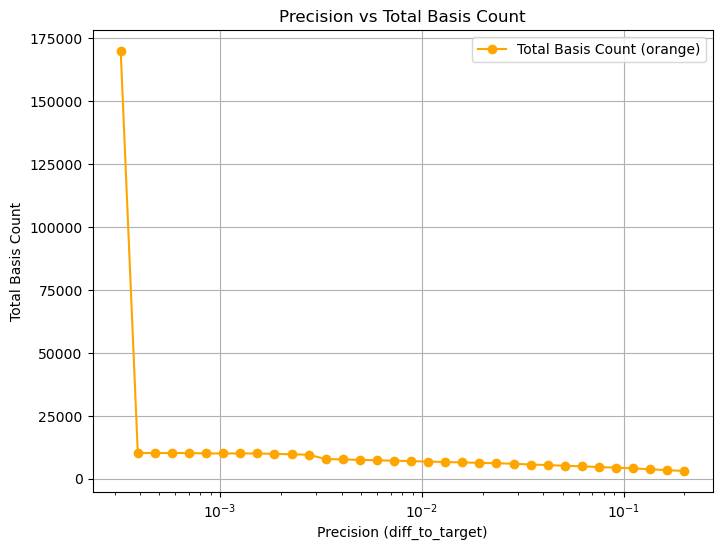

In [30]:
total_count_list = []  # 存储每个 precision 下的 gate 总数
fidelity_list = []
for threshold in precision_list:
    # 初始化电路
    qc_initial = uniform_superposition_circuit()
    
    # 运行 main_loop
    beta_list, energy_list, final_circuit = main_loop_2(
        qc=qc_initial,
        cost_h=cost_h,
        driver_h=driver_h,
        comm_h=comm_h,
        delta_t=delta_t,
        beta_0=beta_0,
        n_steps=n_steps,
        diff_threshold=threshold
    )

    # Transpile 电路
    transpiled_circuit = transpile(
        final_circuit,
        basis_gates=basis_gates,
        coupling_map=linear_coupling,
        optimization_level=1
    )

    # 统计 gate count
    gate_counts = transpiled_circuit.count_ops()
    total_count = sum(gate_counts.values())  # 所有 gate 总数
    total_count_list.append(total_count)

    # 计算 expected fidelity
    expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)
    fidelity_list.append(expected_fidelity)
    print(f"Threshold: {threshold:.6f}, Expected Fidelity: {expected_fidelity:.6f}, Total Gates: {total_count}")

    if fidelity_list[-1] < 0.0001:
        print("Expected fidelity reached zero, exiting loop early.")
        break

# 绘图1: Precision vs Expected Fidelity
plt.figure(figsize=(8, 6))
plt.plot(precision_list[:len(fidelity_list)], fidelity_list, marker='o', label='Expected Fidelity (blue)')
plt.xscale('log')
plt.xlabel('Precision (diff_to_target)')
plt.ylabel('Expected Fidelity')
plt.title('Precision vs Expected Fidelity')
plt.grid(True)
plt.legend()
plt.show()

# 绘图2: Precision vs Total Basis Count (橙色)
plt.figure(figsize=(8, 6))
plt.plot(precision_list[:len(total_count_list)], total_count_list, marker='o', color='orange', label='Total Basis Count (orange)')
plt.xscale('log')
plt.xlabel('Precision (diff_to_target)')
plt.ylabel('Total Basis Count')
plt.title('Precision vs Total Basis Count')
plt.grid(True)
plt.legend()
plt.show()
